## Loading Libraries

In [164]:
import numpy as np
import pandas as pd

## Loading Dataset

In [165]:
import pandas as pd
import statsmodels.api as sm

# Load sunspots dataset
df = sm.datasets.sunspots.load_pandas().data

# Convert YEAR to datetime index
df['YEAR'] = pd.to_datetime(df['YEAR'], format='%Y')


print(df.head())

        YEAR  SUNACTIVITY
0 1700-01-01          5.0
1 1701-01-01         11.0
2 1702-01-01         16.0
3 1703-01-01         23.0
4 1704-01-01         36.0


In [16]:
df.shape

(309, 2)

In [17]:
df.isnull().sum()

,0
YEAR,0
SUNACTIVITY,0


No value is missing.

In [166]:
df['YEAR'] = pd.to_datetime(df['YEAR'])
df['Year'] = df['YEAR'].dt.year

In [24]:
df.describe()

,YEAR,SUNACTIVITY,Year
count,309,309.000000,309.000000
mean,1853-12-31 20:30:17.475727872,49.752104,1854.000000
min,1700-01-01 00:00:00,0.000000,1700.000000
25%,1777-01-01 00:00:00,16.000000,1777.000000
50%,1854-01-01 00:00:00,40.000000,1854.000000
75%,1931-01-01 00:00:00,69.800000,1931.000000
max,2008-01-01 00:00:00,190.200000,2008.000000
std,NaN,40.452595,89.344838


In [167]:
# splitting data for testing from 2021
dtrain = df[df['Year']<1931]
dtest = df[df['Year']>=1931]

In [26]:
dtrain.shape

(231, 3)

In [27]:
dtest.shape

(78, 3)

In [28]:
df.shape

(309, 3)

# Data preparation

## Training data

In [168]:
from sklearn.preprocessing import MinMaxScaler
Xt = dtrain[['Year', 'SUNACTIVITY']]
scaler = MinMaxScaler()
model = scaler.fit(Xt)
scaled_data = model.transform(Xt)

In [30]:
scaled_data.shape

(231, 2)

In [169]:
data_X = []
data_y = []
length_seq = 15
for i in range(scaled_data.shape[0] - length_seq):
  data_X.append(scaled_data[i:i+length_seq])
  data_y.append(scaled_data[i+length_seq][1])
data_X = np.array(data_X)
data_y = np.array(data_y)

In [172]:
data_X.shape, data_y.shape

((216, 15, 2), (216,))

Train - validation

In [173]:
split = int(0.8*(data_X.shape[0]))

val_data_X = data_X[split:]
val_data_Y = data_y[split:]

data_X = data_X[:split]
data_y = data_y[:split]


## Testing data

In [174]:
from sklearn.preprocessing import MinMaxScaler
Xdt = dtest[['Year', 'SUNACTIVITY']]
scaler = MinMaxScaler()
model = scaler.fit(Xt)
scaled_data_test = model.transform(Xdt)

In [ ]:
scaled_data_test.shape

(309, 4)

In [176]:
data_test_X = []
data_test_y = []
length_seq = 15
for i in range(scaled_data_test.shape[0] - length_seq):
  data_test_X.append(scaled_data_test[i:i+length_seq])
  data_test_y.append(scaled_data_test[i+length_seq][1])
data_test_X = np.array(data_test_X)
data_test_y = np.array(data_test_y)

# RNN Modelling

Loss function Mean Squared error

    L(pred,actual) =  1/2 * (pred - actual)^2


Activation function:

    sigmoid(x) = 1/(1+e^-x)
  

Forward propagation

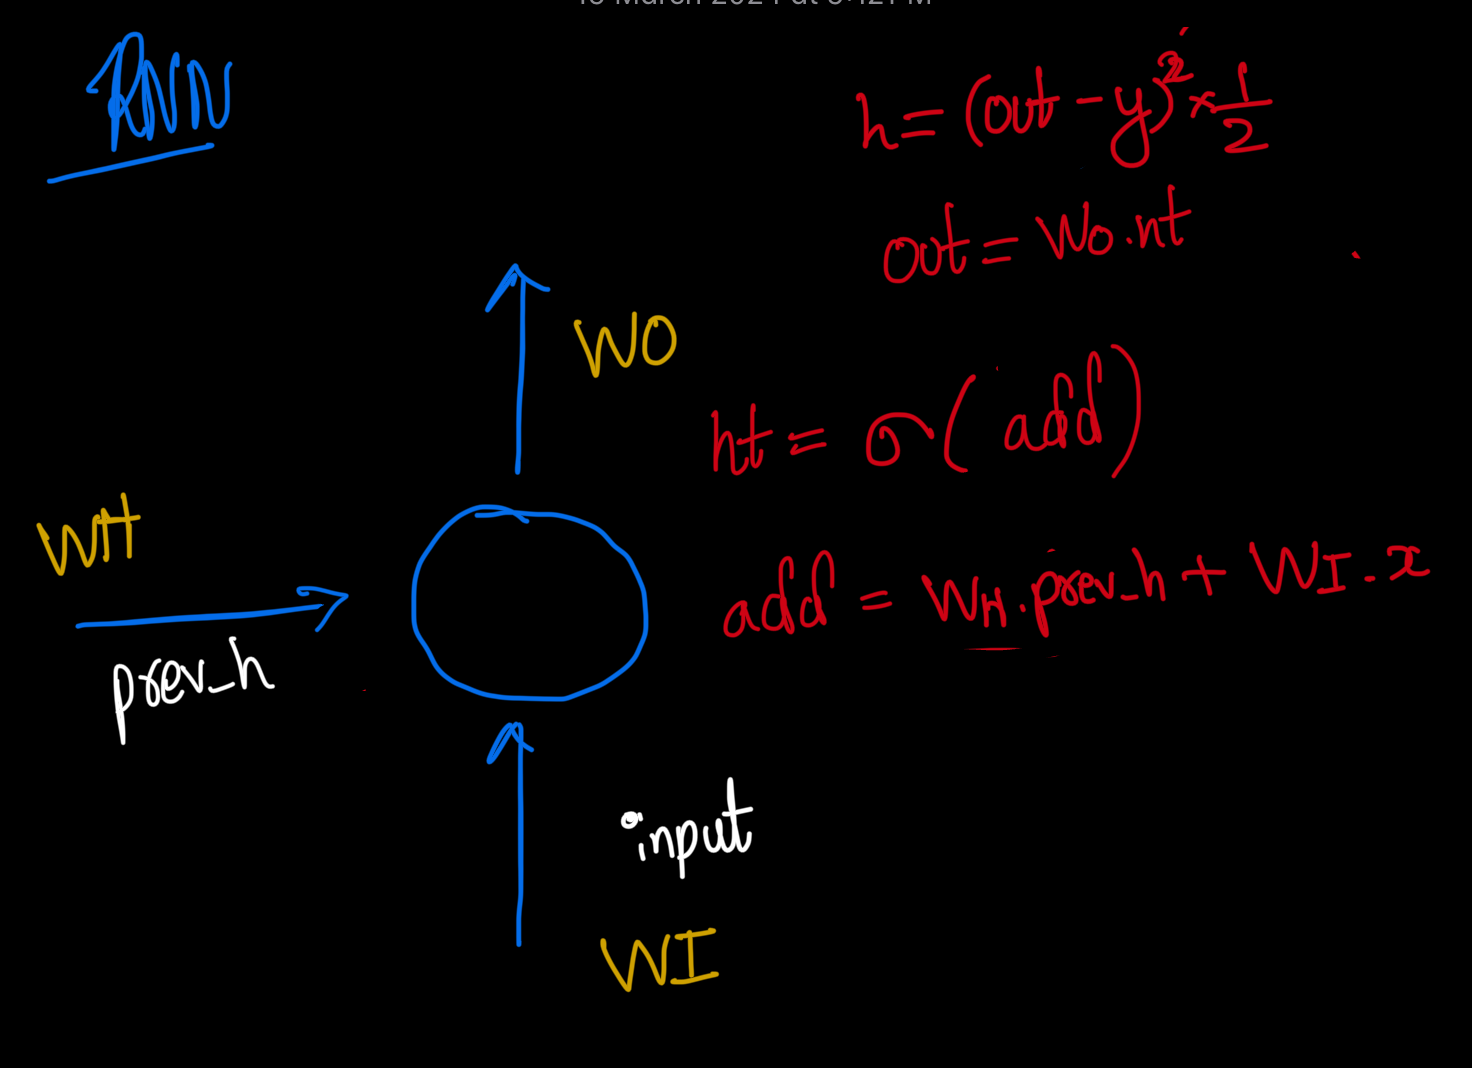

Backward Propagation equations for derivative calculations

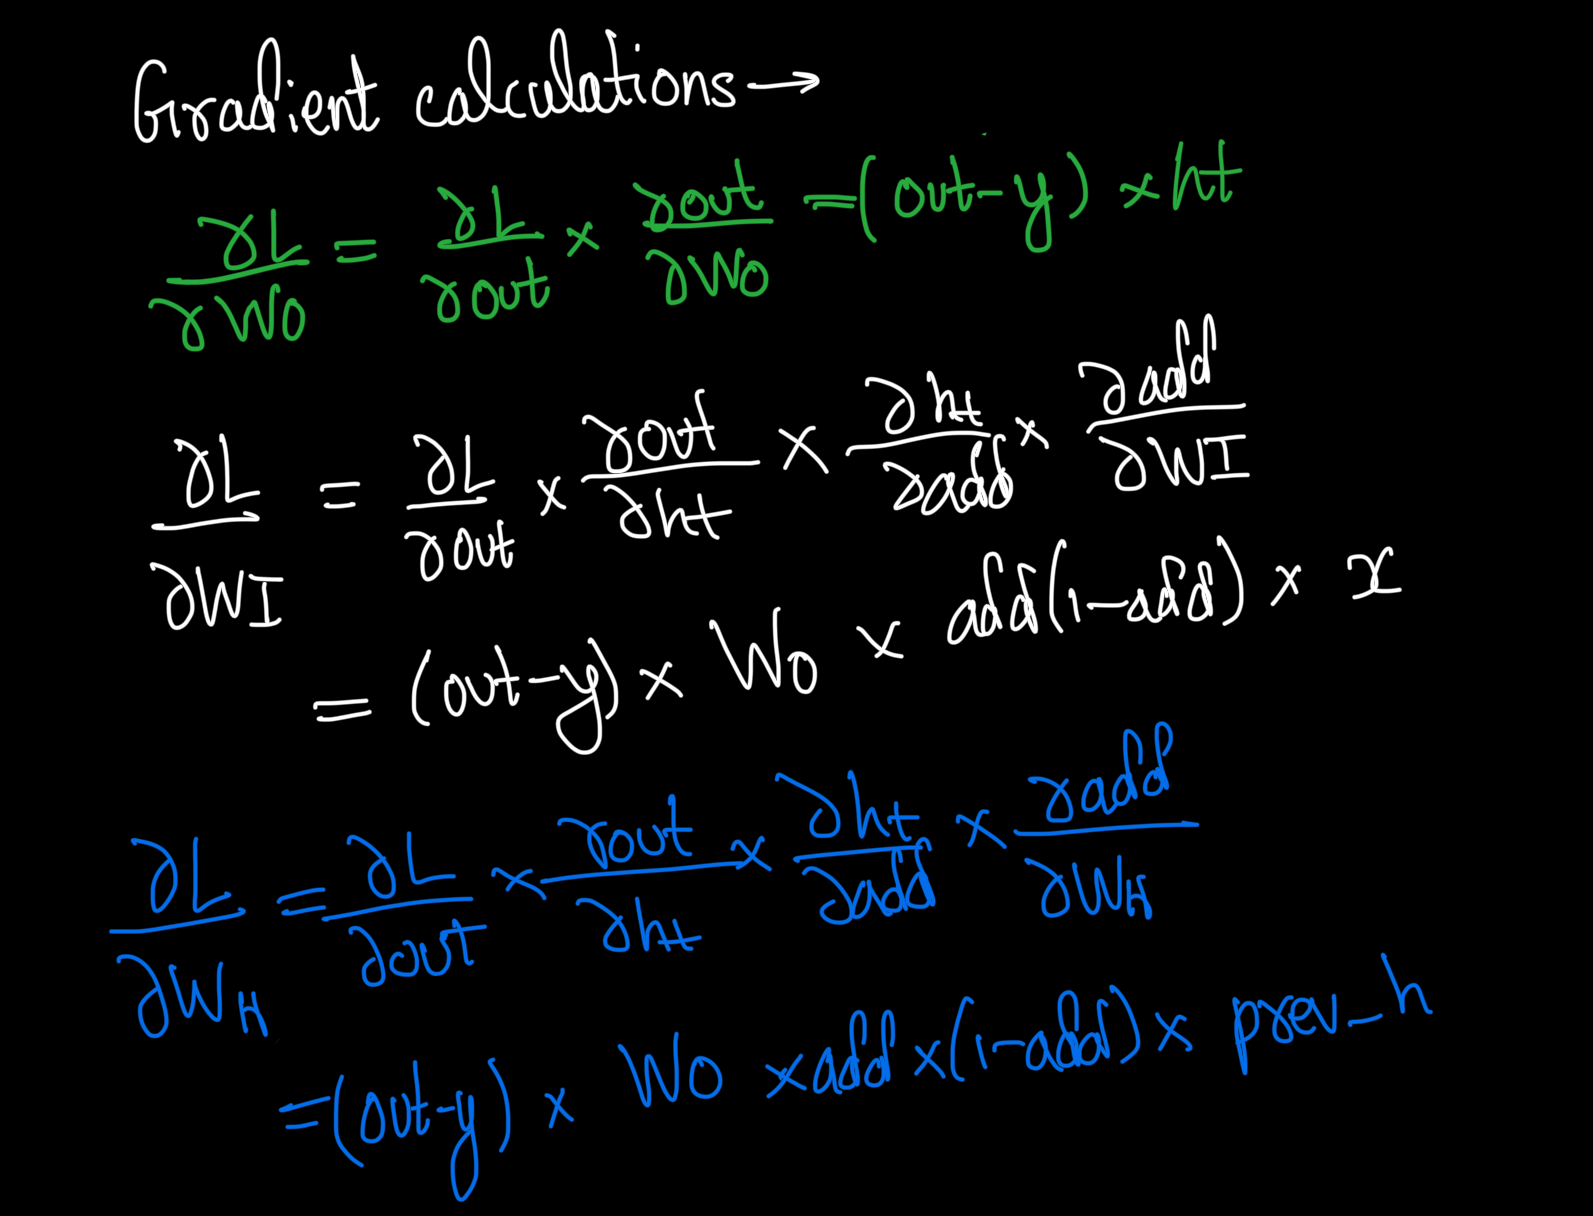

In [177]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

A change in code where we are using tanh instead of sigmoid, but gradient calculations are similar with small change.

In [178]:
#learning rate
lr = 0.001

hidden_dim = 250
# sequence length
length_seq = 10

output_dim = 1
# truncated backprop parameter
bptt_truncate = 10
# Settting limits to avoid vanishing and exploding grads
min_clip_value = -10
max_clip_value = 10

np.random.seed(1)
input_dim = 2
# Initializing Weight matrices
WI  = np.random.uniform(0,1, (hidden_dim, input_dim))
WH = np.random.uniform(0,1, (hidden_dim, hidden_dim))
WO = np.random.uniform(0,1,(output_dim, hidden_dim))

In [179]:

nepochs = 60
X = data_X
Y = data_y

# Hyperparameters (example values, you'd define these earlier)
# hidden_dim = 10
input_dim = X.shape[2]  # Assuming X is (n_samples, length_seq, input_dim)
length_seq = X.shape[1]
lr = 0.001
min_clip_value = -10
max_clip_value = 10
bptt_truncate = 10  # Example value

# Initialize weights (these should be initialized before the loop)
WI = np.random.randn(hidden_dim, input_dim) * 0.01
WH = np.random.randn(hidden_dim, hidden_dim) * 0.01
WO = np.random.randn(1, hidden_dim) * 0.01

for epoch in range(nepochs):
    loss = 0.0
    nrows = Y.shape[0]

    for i in range(nrows):
        # Input & target
        x = X[i]  # (length_seq, input_dim)
        y = Y[i].reshape(1, 1)  # (1,1)

        # Hidden state initialization
        prev_h = np.zeros((hidden_dim, 1))

        # Store forward pass states
        layers_hidden_states = []

        # Forward pass
        for t in range(length_seq):
            xt_col = x[t].reshape(input_dim, 1)

            mulu = np.dot(WI, xt_col)
            mulw = np.dot(WH, prev_h)

            add = mulu + mulw
            ht = np.tanh(add)  # Using tanh is generally better
            # Note: The original code used sigmoid. Tanh is a good alternative.

            layers_hidden_states.append({"ht": ht.copy(), "prev_h": prev_h.copy(), "xt": xt_col.copy()})
            prev_h = ht

        # Output from last timestep
        out = np.dot(WO, prev_h)  # (1,1)

        # Loss accumulation
        row_loss = 0.5 * (out - y) ** 2
        loss += row_loss

        # --- Backward pass ---
        dout = (out - y)  # (1,1)

        # Gradients for a single example
        dWI = np.zeros_like(WI)
        dWH = np.zeros_like(WH)
        dWO = np.zeros_like(WO)

        # Backpropagate through the output layer
        final_ht = layers_hidden_states[length_seq - 1]['ht']
        dWO += np.dot(dout, final_ht.T)  # Correctly compute dWO once

        # Backpropagate into the final hidden state
        dh_next = np.dot(WO.T, dout)

        # Loop backwards through time for BPTT
        for t in reversed(range(length_seq)):
            ht = layers_hidden_states[t]['ht']
            prev_h = layers_hidden_states[t]['prev_h']
            xt = layers_hidden_states[t]['xt']

            # Gradient for the activation
            dadd = dh_next * (1 - ht * ht)  # tanh derivative: 1 - h^2

            # Truncated BPTT
            if t > 0:
                dh_next_prev = np.dot(WH.T, dadd)
            else:
                dh_next_prev = np.zeros_like(dadd)

            if t < length_seq - 1 and t < length_seq - bptt_truncate:
                # Truncate the backpropagation
                dh_next = np.zeros_like(dh_next)
            else:
                dh_next = dh_next_prev

            # Update gradients for WI and WH
            dWI += np.dot(dadd, xt.T)
            dWH += np.dot(dadd, prev_h.T)

        # Gradient clipping
        dWI = np.clip(dWI, min_clip_value, max_clip_value)
        dWO = np.clip(dWO, min_clip_value, max_clip_value)
        dWH = np.clip(dWH, min_clip_value, max_clip_value)

        # Update weights
        WI -= lr * dWI
        WO -= lr * dWO
        WH -= lr * dWH

    # Average training loss
    loss /= float(nrows)
    print(f"Epoch {epoch+1}/{nepochs} - Training Loss: {loss.item():.6f}")

    # --- Validation ---
    predictions = []
    val_loss = 0.0
    nrows_t = val_data_X.shape[0]

    for j in range(nrows_t):
        x_seq = val_data_X[j]
        y_true = val_data_Y[j].reshape(1, 1)

        prev_h = np.zeros((hidden_dim, 1))

        for t in range(length_seq):
            xt_col = x_seq[t].reshape(input_dim, 1)
            mulu = np.dot(WI, xt_col)
            mulw = np.dot(WH, prev_h)
            ht = np.tanh(mulu + mulw)  # Consistent activation function
            prev_h = ht

        out = np.dot(WO, prev_h)  # (1,1)
        predictions.append(out.item())
        val_loss += 0.5 * (out - y_true) ** 2

    val_loss /= float(nrows_t)
    print(f"Validation Loss: {val_loss.item():.6f}")

Epoch 1/60 - Training Loss: 0.072410
Validation Loss: 0.045936
Epoch 2/60 - Training Loss: 0.072075
Validation Loss: 0.045553
Epoch 3/60 - Training Loss: 0.071741
Validation Loss: 0.045170
Epoch 4/60 - Training Loss: 0.071404
Validation Loss: 0.044783
Epoch 5/60 - Training Loss: 0.071063
Validation Loss: 0.044393
Epoch 6/60 - Training Loss: 0.070717
Validation Loss: 0.043997
Epoch 7/60 - Training Loss: 0.070365
Validation Loss: 0.043593
Epoch 8/60 - Training Loss: 0.070005
Validation Loss: 0.043181
Epoch 9/60 - Training Loss: 0.069635
Validation Loss: 0.042757
Epoch 10/60 - Training Loss: 0.069254
Validation Loss: 0.042322
Epoch 11/60 - Training Loss: 0.068860
Validation Loss: 0.041873
Epoch 12/60 - Training Loss: 0.068452
Validation Loss: 0.041409
Epoch 13/60 - Training Loss: 0.068029
Validation Loss: 0.040929
Epoch 14/60 - Training Loss: 0.067589
Validation Loss: 0.040430
Epoch 15/60 - Training Loss: 0.067131
Validation Loss: 0.039912
Epoch 16/60 - Training Loss: 0.066652
Validation 

# Prediction

In [180]:
from sklearn.metrics import mean_squared_error
def calculate_rmse(pred,act):
  print("RMSE:", np.sqrt(mean_squared_error(act, pred)))

def calculate_r2_score(predictions, actual):
    """
    Calculates the R-squared (R2) score.

    Args:
        predictions (list or np.array): A list or NumPy array of predicted values.
        actual (list or np.array): A list or NumPy array of actual values.

    Returns:
        float: The calculated R2 score.
    """
    predictions = np.array(predictions).flatten()
    actual = np.array(actual).flatten()

    # Total sum of squares
    ss_total = np.sum((actual - np.mean(actual)) ** 2)

    # Residual sum of squares
    ss_residual = np.sum((actual - predictions) ** 2)

    # R2 Score
    if ss_total == 0:
        # Avoid division by zero, return 1 if actual values are constant.
        return 1.0
    r2 = 1 - (ss_residual / ss_total)
    return r2

## Training data

In [181]:
X = data_X
Y = data_y
predictions = []
nrows = data_X.shape[0]
for i in range(nrows):
  x, y = X[i], Y[i].reshape(1,1)
  # Hidden state initialization
  prev_h = np.zeros((hidden_dim, 1))
  # Store forward pass states
  layers_hidden_states = []
  for t in range(length_seq):
    xt_col = x[t].reshape(input_dim, 1)


    # Wi @ x
    mulu = np.dot(WI,xt_col)
    # Wh @ h(t-1)
    mulw = np.dot(WH, prev_h)
    #  h(t) = Wi @ x +  Wh @ h(t-1)
    add = mulw + mulu
    # sigmoid activation function
    ht = np.tanh(add)

    layers_hidden_states.append({"ht": ht.copy(), "prev_h": prev_h.copy(), "xt": xt_col.copy()})
    prev_h = ht
  # Wo @ h(t)
  out = np.dot(WO,prev_h)
  predictions.append(out)

In [182]:
predictions = np.array(predictions)
pred = predictions[:, 0, 0]
act = Y
calculate_rmse(pred,act)

RMSE: 0.2141671828563099


## Test data

In [183]:
predictions = []
nrows = data_test_X.shape[0]
X = data_test_X
Y = data_test_y

# Assuming WI, WH, WO, and sigmoid() are defined elsewhere
# Assuming hidden_dim and length_seq are also defined

for i in range(nrows):
    x = X[i]  # Get the entire input sequence for the current example
    y = Y[i]  # Get the true label (though not used in prediction)

    # Initialize the hidden state for the new sequence
    prev_h = np.zeros((hidden_dim, 1))

    # Iterate through the sequence timestep by timestep
    for t in range(length_seq):
        xt_col = x[t].reshape(input_dim, 1)  # Get the input for the current timestep

        # Perform the forward pass for the current timestep
        mulu = np.dot(WI, xt_col)         # Correct: WI @ x[t]
        mulw = np.dot(WH, prev_h)         # Correct: WH @ h(t-1)
        add = mulu + mulw
        ht = np.tanh(add)                 # Compute the new hidden state

        # Update the previous hidden state for the next timestep
        prev_h = ht

    # The output is calculated only after the final timestep
    out = np.dot(WO, prev_h)
    predictions.append(out.item()) # .item() to get the scalar value

In [184]:
predictions = np.array(predictions)

In [185]:
pred = predictions
act = Y
calculate_rmse(pred,act)

RMSE: 0.28533346094003853


In [186]:
calculate_r2_score(pred,act)

np.float64(0.29366703838669994)